# A brief introduction to `simpleQE`

`simpleQE` is an easy-interface quadratic estimator, with intended application for cosmological 21 cm intensity mapping surveys. One can use it to estimate 1D visibility-based delay spectra (what we demonstrate here), as well as 3D image cube power spectra.

Nick Kern
<br>
March 2023

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal
import copy

import simpleqe as sqe
import palettable as pt  # pip install this

## Setup Your Covariance Matrices

These will be used in our GPR analysis, but also to generate mock data.

In [2]:
def Cfg(freqs, variance=1e3, length_scale=5e6):
    """
    A Gaussian foreground covariance
    
    freqs : array_like, (Nfreqs, 1)
        frequency array in Hz
    variance : float
        Amplitude of diagonal
    length_scale : float
        length scale parameter (Hz)
    """
    return variance * np.exp(-0.5 * (freqs - freqs.T)**2 / length_scale**2)

def Cn(freqs, variance=1):
    """
    A white noise covariance
    
    freqs : array_like, (Nfreqs, 1)
        frequency array in Hz
    variance : float
        Amplitude of diagonal
    """
    return variance * np.eye(len(freqs))

def Ceor(freqs, variance=1e-1, length_scale=1e6):
    """
    An exponential EoR covariance
    
    freqs : array_like, (Nfreqs, 1)
        frequency array in Hz
    variance : float
        Amplitude of diagonal
    length_scale : float
        length scale parameter (Hz)
    """
    return variance * np.exp(-np.abs(freqs - freqs.T) / length_scale)

In [3]:
# scatter plot function
def errorbar(ax, kp, y, yerr=None, W=None, fmt='o', ks=np.s_[:], **kwargs):
    if W is not None:
        # get x bins and errorbars from window functions
        x, xerr_low, xerr_hi = sqe.utils.interp_Wcdf(W, kp)
        xerr = np.array([[xerr_low], [xerr_hi]]).T
    else:
        x = kp
        xerr = np.zeros((len(kp), 1, 2))
    if yerr is None:
        yerr = np.array([None] * len(y))
    
    # iterate over points and plot
    p = []
    for xp, yp, ye, xe in zip(x[ks], y[ks], yerr[ks], xerr[ks]):
        p.append(ax.errorbar(xp, yp, ls='', xerr=xe.T, yerr=ye, fmt=fmt, **kwargs))

    return p

## Generate Data for Delay Spectrum

Generate mock data. This is a simple simulation of independent realizations of the visibility from a single baseline over multiple (uncorrelated) observation times.

In [4]:
# generate frequencies
freqs = np.linspace(130e6, 140e6, 50, endpoint=True)  # Hz
Nfreqs = len(freqs)
cosmo = sqe.utils.Cosmology()
reds = cosmo.f2z(freqs)

# convert to line-of-sight distances
x_los = cosmo.comoving_distance(reds[0]).value + (freqs-freqs[0]) * cosmo.dRpara_df(reds[0])

In [5]:
# use single precision if you want
use_single_prec = False
if use_single_prec:
    freqs = freqs.astype(np.float32)
    sqe.utils.set_default_dtype(np.float32)

In [6]:
# simulate fg, eor, noise and stick into container D
# note that D.x1 and D.x2 are the two data realizations, which have the same FG and EoR realizations
# (you can check by comparing F.x1 and F.x2), but have different noise realizations (therefore no noise bias)
Ntimes = 100
D, F, E, N = sqe.utils.gen_data(freqs, Cfg, Ceor, Cn, noise_mult=1,
                                Ntimes=Ntimes, cosmo=cosmo, ind_noise=True, Omega_Eff=0.1)

/Users/nkern/Software/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/stats/_multivariate.py:666: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


Text(0.5, 1, 'Visibility components [arbitrary units]')

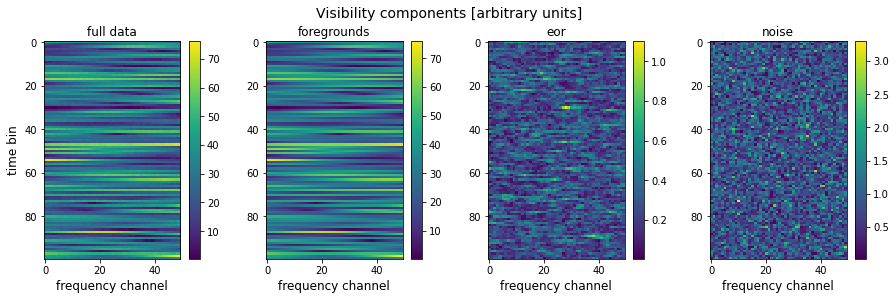

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
fig.subplots_adjust(wspace=.3)

labels = ['full data', 'foregrounds', 'eor', 'noise']
for i, q in enumerate([D, F, E, N]):
    ax = axes[i]
    cax = ax.imshow(np.abs(q.x1[0].T), aspect='auto', interpolation='None')
    fig.colorbar(cax, ax=ax)
    ax.set_title(labels[i], fontsize=12)
    ax.set_xlabel('frequency channel', fontsize=12)
    if i == 0:
        ax.set_ylabel('time bin', fontsize=12)
fig.suptitle("Visibility components [arbitrary units]", fontsize=14, y=1)

__Figure 1__ | Components of the data in the visibility, simulated in arbitrary units with each time bin being uncorrelated from the next.

## Perform GPR-FS

In [8]:
# generate weighting matrices
I = np.eye(Nfreqs).astype(sqe.utils.fdtype())
t = np.diag(signal.windows.blackmanharris(Nfreqs)).astype(sqe.utils.fdtype())  # tapering function
gpr_fs = I - F.C @ np.linalg.pinv(D.C)
gpr_fs = gpr_fs.astype(sqe.utils.fdtype())

In [9]:
# set R matrices
D.set_R(gpr_fs); F.set_R(t); E.set_R(I); N.set_R(I)

In [10]:
# compute qft
D.compute_qft(); F.compute_qft(); E.compute_qft(); N.compute_qft()

In [11]:
# compute H
D.compute_H(); F.compute_H(); E.compute_H(); N.compute_H()

In [12]:
# compute un-normalized band power: q
D.compute_q(); F.compute_q(); E.compute_q(); N.compute_q()

In [13]:
# compute normalization, window func, V, and normalized p (and spherically average it)
D.compute_MWVp(norm='H^-1/2', C_errs=D.C, C_bias=F.C)  # no noise bias (see above)
F.compute_MWVp(norm='I')
E.compute_MWVp(norm='I')
N.compute_MWVp(norm='I', C_errs=N.C)

In [14]:
# average negative and positive bandpowers
D.fold_bandpowers()
F.fold_bandpowers()
E.fold_bandpowers()
N.fold_bandpowers()

Text(0, 0.5, '$W(k)$')

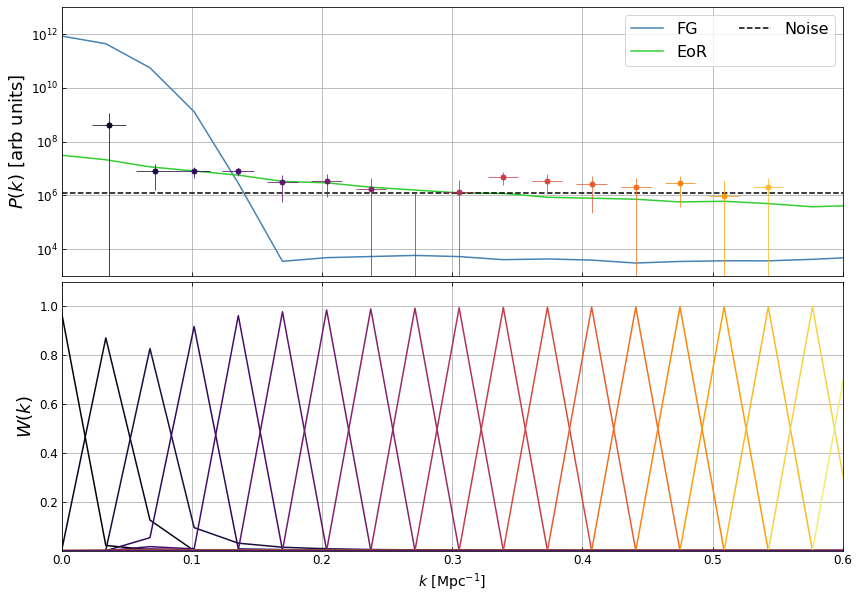

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.subplots_adjust(hspace=0.02)

xlim = 0.0, 0.6
ylim = 1e3, 1e13
prop_cycle = pt.matplotlib.Inferno_20.mpl_colors

ax = axes[0]
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
# plot FG averaged over time
p1, = ax.plot(F.k_avg[1], np.abs(np.mean(F.p_avg[0], axis=-1).real), c='steelblue', lw=1.5, alpha=1)
# plot eor averaged over time
p2, = ax.plot(E.k_avg[1], np.abs(np.mean(E.p_avg[0], axis=-1).real), c='limegreen', lw=1.5, alpha=1)
# plot noise averaged over time
p3 = ax.axhline(np.mean(np.abs(np.mean(N.p_avg[0], axis=-1).real)), color='k', ls='--', lw=1.5)
# plot GPR-FS
ax.set_prop_cycle('color', prop_cycle)
errorbar(ax, D.k_avg[1], np.mean(D.p_avg[0] - D.b_avg[0], axis=-1).real,
              yerr=np.sqrt(D.V_avg[1]/Ntimes), fmt='o', ms=5, elinewidth=0.75, W=D.W_avg[1])

ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'$P(k)$ [arb units]', fontsize=18)
ax.legend([p1, p2, p3], ['FG', 'EoR', 'Noise'], fontsize=16, ncol=2)

ax = axes[1]
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(D.k_avg[1], D.W_avg[1].T, lw=1.5, alpha=1)
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(1e-4, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=18)
#ax.set_yscale('log')

__Figure 2__ | Example power spectra of FG (blue), EoR (green), noise floor (black) and recovered power spectra after GPR-FS (points).

## Let's try wideband inpainting

Perform RFI gap inpainting over a wide bandwidth, but estimate power spectrum over the same 10 MHz window. This all happens within the machinery of the QE.

In [60]:
# triple the bandwidth from before
freqs = np.linspace(120e6, 150e6, 150, endpoint=True)  # Hz
Nfreqs = len(freqs)
cosmo = sqe.utils.Cosmology()

In [61]:
# generate a wideband dataset, with a narrowband power spectrum window
Ntimes = 100
D, F, E, N = sqe.utils.gen_data(freqs, Cfg, Ceor, Cn, Ntimes=Ntimes, cosmo=cosmo, ind_noise=True, Omega_Eff=0.1,
                                pspec_spw=slice(50, 100))
D_flagged = copy.deepcopy(D)

In [62]:
# generate flags
flags = np.zeros(Nfreqs, bool)

fchans = [(20, 21), (40, 41), (80, 81), (95, 96), (120, 121)]
for fc in fchans:
    flags[fc[0]:fc[1]] = True

<ipython-input-62-32f4974f56fc>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  flags = np.zeros(Nfreqs, np.bool)


Text(0.5, 0, 'frequency channel')

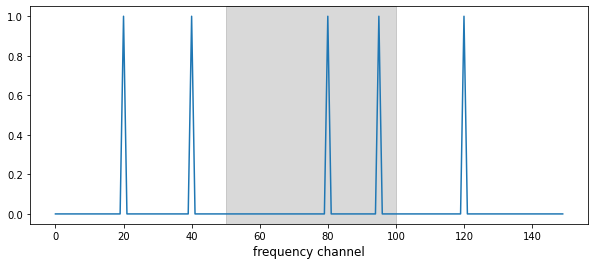

In [63]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.axvspan(50, 100, color='k', alpha=0.15)
ax.plot(flags)
ax.set_xlabel('frequency channel', fontsize=12)

__Figure 3__ | Flagging mask we will apply to the data. Shaded region indicates power spectrum spectral window.

In [85]:
# generate weighting matrices
I = np.eye(Nfreqs)
t = np.eye(Nfreqs)
t[50:100, 50:100] = np.diag(signal.windows.blackmanharris(50))  # tapering function
gpr_fs = I - F.C @ np.linalg.pinv(D.C)

Wf = I.copy()
Wf[~flags, ~flags] = 0.0

# get inpainting matrices across wide bandwidth
gpr_dm = (F.C) @ np.linalg.inv(F.C + N.C + E.C + Wf * 1e10)
gpr_ip = I - Wf + Wf @ gpr_dm

In [86]:
# set R matrices
D.set_R(t @ gpr_ip); D_flagged.set_R(t @ (I-Wf)); F.set_R(t); E.set_R(t); N.set_R(t)

In [87]:
# compute Q and H
D.compute_qft(); D_flagged.compute_qft(); F.compute_qft(); E.compute_qft(); N.compute_qft()
D.compute_H(); D_flagged.compute_H(); F.compute_H(); E.compute_H(); N.compute_H()

# compute un-normalized band power: q
D.compute_q(); D_flagged.compute_q(); F.compute_q(); E.compute_q(); N.compute_q()

# compute normalizations
D.compute_MWVp(norm='I', C_errs=D.C)
D_flagged.compute_MWVp(norm='I')
F.compute_MWVp(norm='I')
E.compute_MWVp(norm='I')
N.compute_MWVp(norm='I')

D.fold_bandpowers(); D_flagged.fold_bandpowers(); F.fold_bandpowers(); E.fold_bandpowers(); N.fold_bandpowers()

Text(0, 0.5, '$W(k)$')

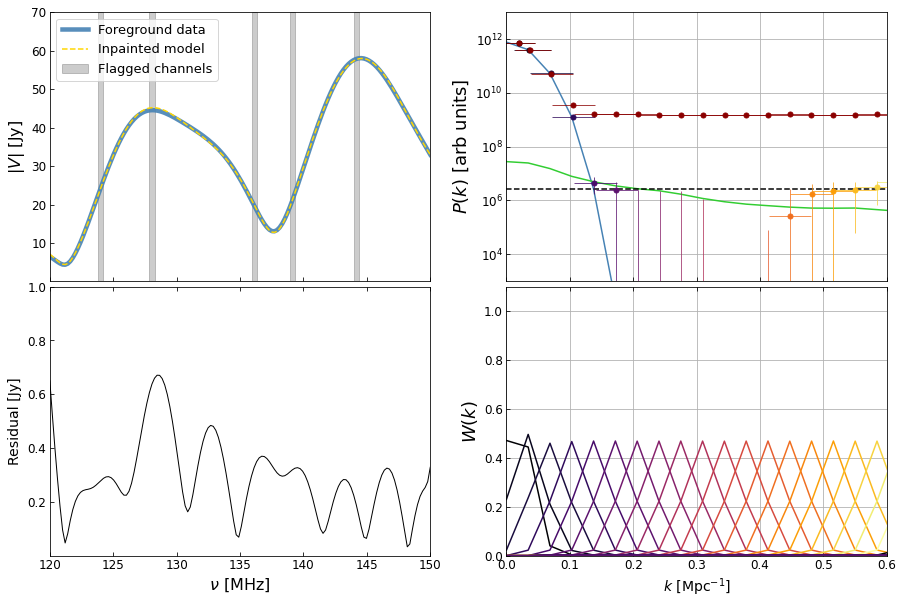

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.02)

xlim = 120, 150
ax = axes[0, 0]
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
ax.axvspan(50, 100, color='limegreen', alpha=0.15)
for fc in fchans:
    ax.axvspan(freqs[fc[0]-1]/1e6, freqs[fc[1]]/1e6, color='k', alpha=0.2)
d = D.x1[0,:,1].copy()
dip = gpr_dm @ d
d[flags] *= np.nan
p0, = ax.plot(freqs/1e6, np.abs(F.x1[0,:,1]), lw=4.5, color='steelblue', alpha=0.9)
p1, = ax.plot(freqs/1e6, np.abs(dip), lw=1.5, color='gold', ls='--')
r = plt.Rectangle((0,0), 0, 0, color='k', alpha=0.2)
ax.set_xlim(xlim)
ax.set_ylim(0.1, 70)
ax.legend([p0, p1, r], ['Foreground data', 'Inpainted model', 'Flagged channels'], fontsize=13)
ax.set_ylabel(r'$|V|$ [Jy]', fontsize=16)
ax.set_xticklabels([])

ax = axes[1, 0]
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
#ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0e'))
ax.plot(freqs/1e6, np.abs(dip - F.x1[0,:,1]), color='k', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(0.0001, 1)
ax.set_xlabel(r'$\nu$ [MHz]', fontsize=16)
ax.set_ylabel(r'Residual [Jy]', fontsize=14, labelpad=5)


xlim = 0.0, 0.6
ylim = 1e3, 1e13
prop_cycle = pt.matplotlib.Inferno_20.mpl_colors

ax = axes[0, 1]
ax.tick_params(labelsize=12, direction='in', size=4)
ax.tick_params(which='minor', size=2, direction='in')
# plot FG averaged over time
p1, = ax.plot(F.k_avg[1], np.abs(np.mean(F.p_avg[0], axis=1).real), c='steelblue', lw=1.5, alpha=1)
# plot eor averaged over time
p2, = ax.plot(E.k_avg[1], np.abs(np.mean(E.p_avg[0], axis=1).real), c='limegreen', lw=1.5, alpha=1)
# plot noise averaged over time
p3 = ax.axhline(np.mean(np.abs(np.mean(N.p_avg[0], axis=1).real)), color='k', ls='--', lw=1.5)
# plot GPR-FS
ax.set_prop_cycle('color', prop_cycle)
errorbar(ax, D.k_avg[1], np.mean(D.p_avg[0], axis=1).real,
         yerr=np.sqrt(D.V_avg[1])/Ntimes), fmt='o', ms=5, elinewidth=0.75, W=D.W_avg[1])
errorbar(ax, D_flagged.k_avg[1], np.mean(D_flagged.p_avg[0], axis=1).real, c='darkred',
         yerr=np.sqrt(D_flagged.V_avg[1]/Ntimes), fmt='o', ms=5, elinewidth=0.75, W=D_flagged.W_avg[1])

ax.grid()
ax.set_yscale('log')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticklabels([])
ax.set_ylabel(r'$P(k)$ [arb units]', fontsize=18)
#ax.legend([p1, p2, p3, p4], ['FG', 'EoR', 'Noise', 'GPR-FS'], fontsize=16, ncol=2)

ax = axes[1, 1]
ax.set_prop_cycle('color', prop_cycle)
ax.tick_params(labelsize=12, direction='in', size=4, top=True)
ax.tick_params(which='minor', size=2, direction='in')
ax.plot(D.k_avg[1], D.W_avg[1].T, lw=1.5, alpha=1)
ax.grid()
ax.set_xlim(xlim)
ax.set_ylim(-.0, 1.10)
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$', fontsize=14)
ax.set_ylabel(r'$W(k)$', fontsize=18)

__Figure 4__ | Foreground inpainting in frequency space (left) and the associated power spectra (right). Red points are the flagged but un-inpainted dataset. 

# QE for an image cube

Only including foregrounds and noise in this demo. This requires at least 6 GB of RAM.

In [98]:
import pygdsm  # pip install this
import healpy

In [99]:
# generate frequencies
freqs = np.linspace(130e6, 140e6, 50, endpoint=True)  # Hz
Nfreqs = len(freqs)
cosmo = sqe.utils.Cosmology()
reds = cosmo.f2z(freqs)

# convert to line-of-sight comoving distances (for 21 cm line)
z_los = cosmo.comoving_distance(reds[0]).value + (freqs-freqs[0]) * cosmo.dRpara_df(reds.mean())
dz = z_los[1] - z_los[0]

In [100]:
# generate ra, dec values for an image cube
ra = np.linspace(25, 35, 128)
dec = np.linspace(-35, -25, 128)
RA, DEC = np.meshgrid(ra, dec)
RA, DEC = RA.ravel(), DEC.ravel()
dy = (ra[1] - ra[0]) * cosmo.dRperp_dtheta(reds.mean()) * np.pi / 180

In [101]:
# generate foregrounds
GSM = pygdsm.GSMObserver()
gsm = np.array([healpy.get_interp_val(GSM.generate(f/1e6), (90-DEC)*np.pi/180, RA*np.pi/180) for f in freqs])
gsm = gsm.reshape(len(freqs), len(ra), len(dec)).T

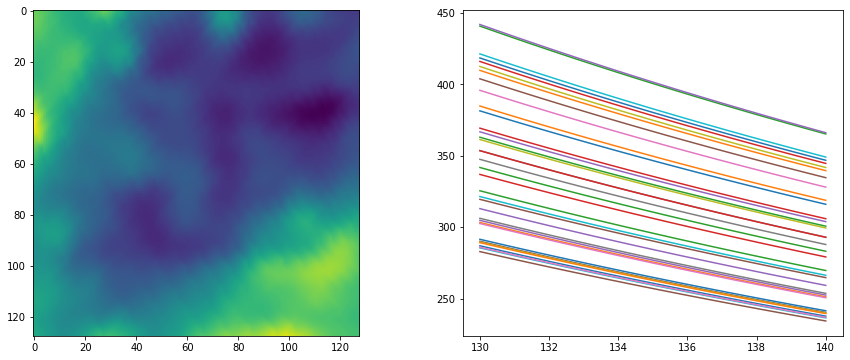

In [102]:
# plot spatial and frequency behavior of foregrounds
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(gsm[:,:,0])
axes[1].plot(freqs/1e6, gsm[::25, ::25].reshape(-1, len(freqs)).T);

In [103]:
# generate (uncorrelated) noise: 25 random realizations
np.random.seed(0)
noise1 = np.random.normal(0, 1, gsm.shape + (30,))
noise2 = np.random.normal(0, 1, gsm.shape + (30,))

# add frequency tilt to noise amplitude given FG amplitude
noise1 *= gsm.mean((0, 1))[..., None] * 1e-2
noise2 *= gsm.mean((0, 1))[..., None] * 1e-2

In [104]:
# estimate image-space noise variances
Cx = Cy = np.eye(len(ra)) * np.var(noise1, axis=(2, 3)).mean()
Cz = np.eye(len(freqs)) * np.var(noise1, axis=(0, 1, 3))

In [105]:
use_single_prec = False
if use_single_prec:
    freqs = freqs.astype(np.float32)
    gsm = gsm.astype(np.float32)
    noise1 = noise1.astype(np.float32)
    noise2 = noise2.astype(np.float32)
    Cx = Cx.astype(np.float32)
    Cy = Cy.astype(np.float32)
    Cz = Cz.astype(np.float32)
    sqe.utils.set_default_dtype(np.float32)

In [106]:
# instantiate objects
D = sqe.qe.QE(gsm[..., None] + noise1, [dy, dy, dz], x2=gsm[..., None] + noise2, scalar=None)
N = sqe.qe.QE(noise1, [dy, dy, dz], x2=noise2, scalar=None)

In [107]:
# run QE
tz = np.diag(signal.windows.blackmanharris(len(freqs))).astype(sqe.utils.fdtype())
txy = np.diag(signal.windows.hamming(len(ra))).astype(sqe.utils.fdtype())
# set RA, Dec, freq weighting functions
D.set_R([txy, txy, tz]); N.set_R([txy, txy, tz])

In [108]:
D.compute_qft(); N.compute_qft()

In [109]:
D.compute_H(); N.compute_H()

In [110]:
D.compute_q(); N.compute_q()

In [111]:
D.compute_MW(norm='I'); N.compute_MW(norm='I')

In [112]:
D.compute_p(); N.compute_p()

In [113]:
# compute full covariance to test noise propagation (diag=False)
# the None indicates that we broadcast the Cz covariance in the x and y direction
# 1/sqrt(2) b/c we fed noise1 and noise2
N.compute_V(C=[Cx, Cy, Cz/np.sqrt(2)], diag=False, unnorm_ax=2)
D.compute_V(C=None, diag=True) 

<ipython-input-114-c7ea01d2360c>:3: RuntimeWarning: invalid value encountered in log10
  cax = axes[0].matshow(np.log10(D.p[:,:,25,0].real), aspect='auto',
<ipython-input-114-c7ea01d2360c>:7: RuntimeWarning: invalid value encountered in log10
  cax = axes[1].matshow(np.log10(D.p[50,:,:,0].real), aspect='auto',


Text(0, 0.5, 'k_y')

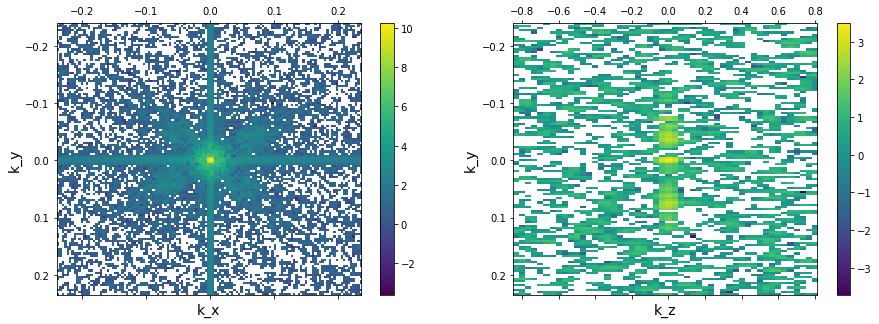

In [114]:
# plot slices of 3D power spectra
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
cax = axes[0].matshow(np.log10(D.p[:,:,25,0].real), aspect='auto',
                     extent=[D.k[0][0], D.k[0][-1], D.k[1][-1], D.k[1][0]])
fig.colorbar(cax, ax=axes[0])
axes[0].set_xlabel('k_x',fontsize=14); axes[0].set_ylabel('k_y', fontsize=14)
cax = axes[1].matshow(np.log10(D.p[50,:,:,0].real), aspect='auto',
                     extent=[D.k[2][0], D.k[2][-1], D.k[0][-1], D.k[0][0]])
fig.colorbar(cax, ax=axes[1])
axes[1].set_xlabel('k_z',fontsize=14); axes[1].set_ylabel('k_y', fontsize=14)

Test noise variance computation in 3D space. Use the noise-only estimator for this.

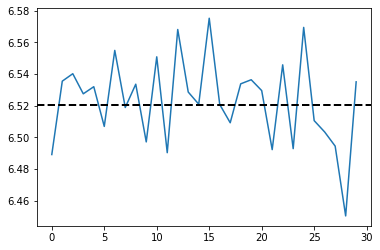

In [116]:
# unravel variances
V = sqe.utils.ravel_mats(len(ra), sqe.utils.ravel_mats(len(ra), np.diag(N.V[2])))

# unravel power spectra
p = N.p.reshape(-1, N.p.shape[-1])

# plot std over cube for each independent realization
plt.plot(np.std(p.real, axis=0))
# plot estimate noise std: 1/sqrt(2) comes from cross multiplying noise1 and noise2
plt.axhline(V.mean()**.5, c='k', ls='--', lw=2)

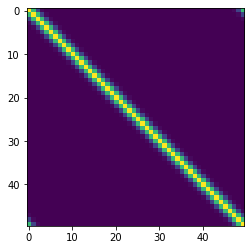

In [117]:
# plot computed k_z vs k_z bandpower covariance
# note that even though input freq-freq covariance was diagonal,
# the bandpower covariance should have non-zero off-diagonal
# due to the applied tapering function along z direction
plt.imshow(N.V[2])

In [118]:
if hasattr(N, 'p_avg'): del N.p_avg
if hasattr(D, 'p_avg'): del D.p_avg

In [119]:
# fold the bandpowers
N.fold_bandpowers(drop_neg_ax=2)
D.fold_bandpowers(drop_neg_ax=2)

**Note: `average_bandpowers()` will take a lot of RAM and time if the bandpower covariances have off-diagonal components and `two_dim=False`! To simplify, use `compute_V(diag=True)` and/or two successive calls with `two_dim=True`.**

In [120]:
# average first two dimensions (kx, ky) first (i.e. cylindrical average)
# note: successive calls to average_bandpowers() overwrites existing p_avg attribute
k_avg = D.k_avg[0]
D.average_bandpowers(k_avg, two_dim=True, diag_weight=True)
N.average_bandpowers(k_avg, two_dim=True, diag_weight=True)

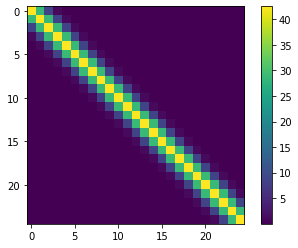

In [121]:
plt.imshow(N.V_avg[1])
plt.colorbar()

<ipython-input-122-57e92c2a2004>:3: RuntimeWarning: invalid value encountered in log10
  cax = plt.imshow(np.log10(D.p_avg[:, :, 0].real.T), origin='lower', aspect='auto',


Text(0, 0.5, '$k_\\parallel$')

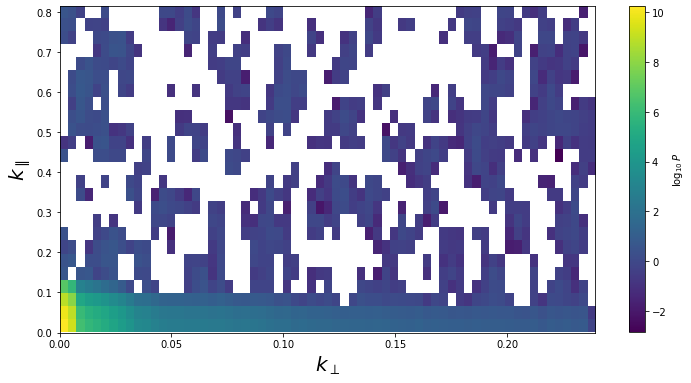

In [122]:
# plot fg + noise 2D pspectra
plt.figure(figsize=(12, 6))
cax = plt.imshow(np.log10(D.p_avg[:, :, 0].real.T), origin='lower', aspect='auto',
                 extent=[D.k_avg[0][0], D.k_avg[0][-1], D.k_avg[1][0], D.k_avg[1][-1]])
plt.colorbar(cax, label=r'$\log_{10}P$')
plt.xlabel(r'$k_\perp$', fontsize=20)
plt.ylabel(r'$k_\parallel$', fontsize=20)

Text(0, 0.5, '$k_\\parallel$')

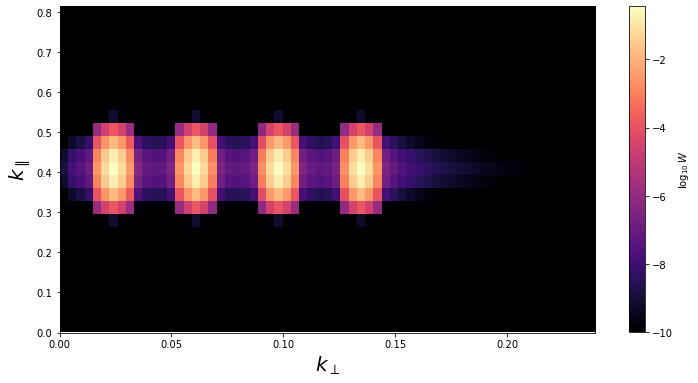

In [123]:
# plot window functions at four different k_perp values
# plot fg + noise 2D pspectra
plt.figure(figsize=(12, 6))
W = sqe.utils.ravel_mats(D.W_avg[0], D.W_avg[1])
n = D.p_avg.shape[1]
W = np.sum([W[6*n + n//2 + n*i*10] for i in range(4)],axis=0).reshape(D.p_avg.shape[:2]).T
cax = plt.imshow(np.log10(W), origin='lower', aspect='auto', cmap='magma', vmin=-10,
                 extent=[D.k_avg[0][0], D.k_avg[0][-1], D.k_avg[1][0], D.k_avg[1][-1]])
plt.colorbar(cax, label=r'$\log_{10}W$')
plt.xlabel(r'$k_\perp$', fontsize=20)
plt.ylabel(r'$k_\parallel$', fontsize=20)

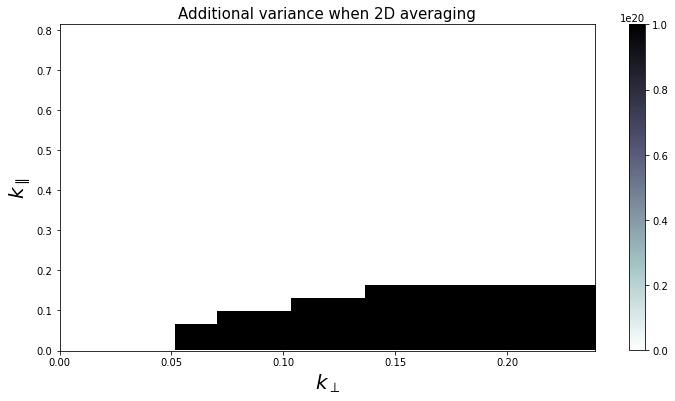

In [124]:
# create a k_perp, k_para weighting function
var_func = None
var_func = lambda kperp, kpara, *args: \
    1e20 * ((kperp.ravel()> .05) & (kpara.ravel() < 0.15) & (kpara.ravel() < kperp.ravel())).astype(float)

plt.figure(figsize=(12, 6))
plt.imshow(var_func(*np.meshgrid(*D.k_avg)).reshape(len(D.k_avg[1]), len(D.k_avg[0])), cmap='bone_r',
           extent=[D.k_avg[0][0], D.k_avg[0][-1], D.k_avg[1][0], D.k_avg[1][-1]],
           origin='lower', aspect='auto')
plt.xlabel(r'$k_\perp$', fontsize=20)
plt.ylabel(r'$k_\parallel$', fontsize=20)
plt.title('Additional variance when 2D averaging', fontsize=15)
plt.colorbar()

In [125]:
# now do spherical average
k_avg = D.k_avg[1]
D.average_bandpowers(k_avg, two_dim=True, diag_weight=True, var_func=var_func)
N.average_bandpowers(k_avg, two_dim=True, diag_weight=True, var_func=var_func)

(0.001, 2)

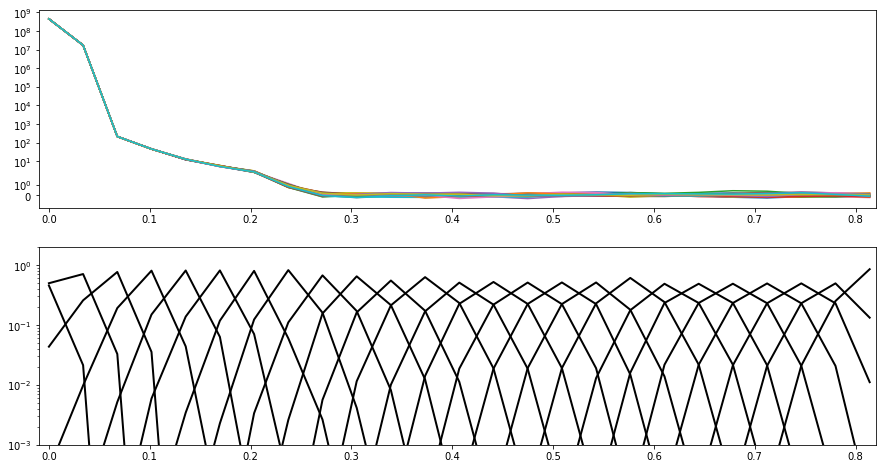

In [126]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

ax = axes[0]
p1 = ax.plot(D.k_avg[0], D.p_avg.real);
ax.set_yscale('symlog')
ax.set_xlim(-.01, 0.82)

ax = axes[1]
ax.plot(D.k_avg[0], D.W_avg[0], c='k', lw=2);
ax.set_yscale('log')
ax.set_xlim(-.01, 0.82)
ax.set_ylim(1e-3, 2)

(0.001, 2)

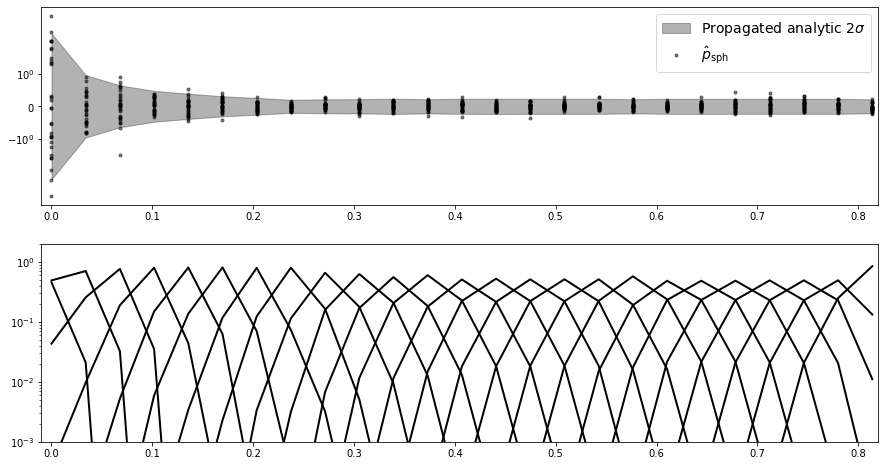

In [127]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

ax = axes[0]
p0 = ax.fill_between(N.k_avg[0], -2*N.V_avg[0].diagonal()**.5, 2*N.V_avg[0].diagonal()**.5, color='k', alpha=0.3)
p1 = ax.plot(N.k_avg[0], N.p_avg.real, alpha=0.5, c='k', marker='.', ls='');
ax.set_yscale('symlog')
ax.legend([p0, p1[0]], [r'Propagated analytic $2\sigma$', r'$\hat{p}_{\rm sph}$'], fontsize=14)
ax.set_xlim(-.01, 0.82)

ax = axes[1]
ax.plot(N.k_avg[0], N.W_avg[0], c='k', lw=2);
ax.set_yscale('log')
ax.set_xlim(-.01, 0.82)
ax.set_ylim(1e-3, 2)

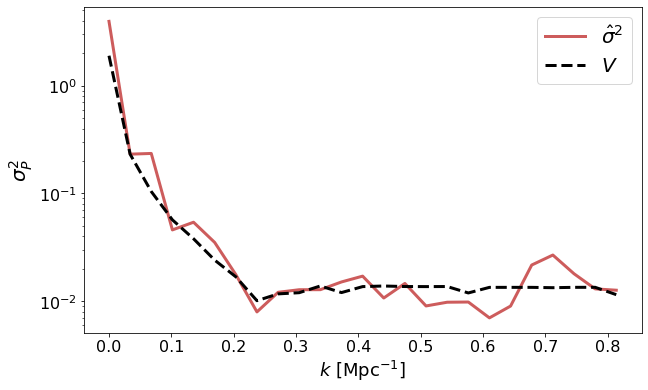

In [128]:
# compare forward propagated variance against estimate variance (on-diagonal terms)
plt.figure(figsize=(10, 6))
plt.tick_params(labelsize=16)
plt.plot(N.k_avg[0], np.var(N.p_avg.real, axis=-1), lw=3, c='indianred', label=r'$\hat{\sigma}^2$')
plt.plot(N.k_avg[0], N.V_avg[0].diagonal(), ls='--', lw=3, c='k', label=r'$V$')
plt.yscale('log')
plt.xlabel(r'$k$ [Mpc$^{-1}]$', fontsize=18)
plt.ylabel(r'$\sigma_P^2$', fontsize=20)
plt.legend(fontsize=20)

Text(0, 0.5, 'Normalized covariance')

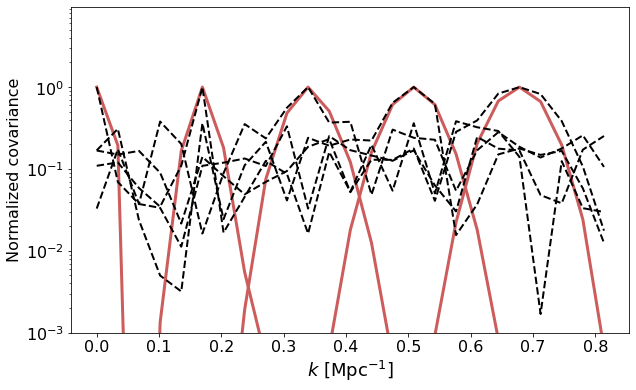

In [130]:
# compare analytic and estimatd covariances (looking at off-diagonal terms)
plt.figure(figsize=(10, 6))
plt.tick_params(labelsize=16)
C = np.diag(1/N.V_avg[0].diagonal()**.5) @ N.V_avg[0] @ np.diag(1/N.V_avg[0].diagonal()**.5)
plt.plot(N.k_avg[0], abs(C[::5].T), c='indianred', lw=3)
C = np.cov(N.p_avg.real)
C = np.diag(1/C.diagonal()**.5) @ C @ np.diag(1/C.diagonal()**.5)
plt.plot(N.k_avg[0], abs(C[::5].T), c='k', lw=2, ls='--')
plt.yscale('log')
plt.ylim(1e-3, )
plt.xlabel(r'$k$ [Mpc$^{-1}$]', fontsize=18)
plt.ylabel('Normalized covariance', fontsize=16)